In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [54]:
import xwmt

### Load grids and data

In [55]:
gridname = 'rho2' # choose from ['zstr', 'natv', 'rho2']
dt = 'monthly' # choose from ['monthly', 'daily', 'hourly']

# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

# Select year-long subset
ds = ds.sel(time=slice(snap.time[0], snap.time[-1]))
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao'})

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)),
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'}
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

In [56]:
import yaml

with open("../../xwmt/conventions/MOM6.yaml", "r") as stream:
    try:
        budgets_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
budgets_dict

{'heat': {'lambda': 'thetao',
  'lhs': {'tendency': 'opotemptend'},
  'rhs': {'horizontal_advection': 'T_advection_xy',
   'vertical_advection': 'Th_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_heat_tendency',
   'vertical_diffusion': 'opottempdiff',
   'neutral_diffusion': 'opottemppmdiff',
   'frazil_ice': 'frazil_heat_tendency',
   'geothermal': 'internal_heat_heat_tendency'},
  'surface_flux': {'total': 'hfds',
   'latent': 'hflso',
   'sensible': 'hfsso',
   'longwave': 'rlntds',
   'shortwave': 'rsntds',
   'frazil_ice': 'hfsifrazil',
   'mass_transfer': 'heat_content_surfwater',
   'basal': None}},
 'salt': {'lambda': 'salt',
  'lhs': {'tendency': 'osalttend'},
  'rhs': {'horizontal_advection': 'S_advection_xy',
   'vertical_advection': 'Sh_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_salt_tendency',
   'vertical_diffusion': 'osaltdiff',
   'neutral_diffusion': 'osaltpmdiff',
   'frazil_ice': None,
   'geothermal': None},
  'surface_flux': {'t

In [57]:
wmt = xwmt.WaterMassTransformations(ds, grid, budgets_dict)

In [58]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    G_temperature = wmt.integrate_transformations("temperature", bins=np.arange(-2, 30, 0.25))
    G_salinity = wmt.integrate_transformations("salinity", bins=np.arange(0, 50, 0.25))
    G_density = wmt.integrate_transformations("sigma2", bins=np.arange(10, 40, 0.25))

In [63]:
F_density = wmt.map_transformations("sigma2", bins=np.arange(10, 40, 0.25))

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

In [59]:
tmp = G_density[[v for v in G_density.data_vars if "surface_flux" in v]]

### Verification that 3D and 2D water mass transformations are consistent.

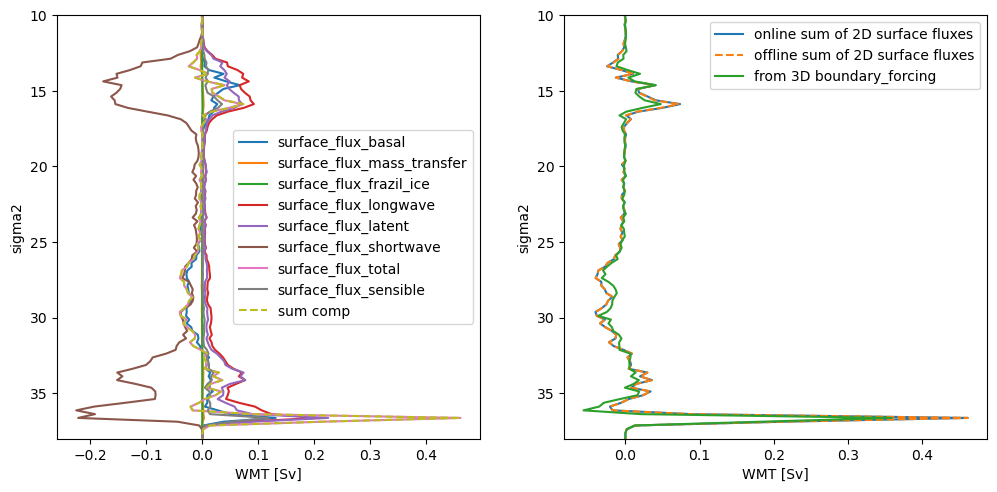

In [60]:
plt.figure(figsize=(12,5.5))
plt.subplot(1,2,1)
flux = xr.zeros_like(G_density['surface_flux_total'])
for k in tmp.data_vars:
    if k!="surface_flux_total":
        flux += tmp[k]
    (tmp[k]*1e-6).mean('time').plot(y="sigma2", label=k)
(flux*1e-6).mean('time').plot(y="sigma2", label="sum comp", ls="--")
plt.legend()
plt.ylim(38, 10)
plt.xlabel("WMT [Sv]")

plt.subplot(1,2,2)
(flux*1e-6).mean('time').plot(label="online sum of 2D surface fluxes", y="sigma2")
(tmp['surface_flux_total']*1e-6).mean('time').plot(ls="--", label="offline sum of 2D surface fluxes", y="sigma2")
(G_density['boundary_forcing']*1e-6).mean('time').plot(label="from 3D boundary_forcing", y="sigma2")
plt.legend()
plt.ylim(38, 10)
plt.xlabel("WMT [Sv]");

There is still a small discrepancy between the 3D surface forcings and the 2D total surface fluxes. I am not totally sure where these errors come from.